# Building Models from scratch
> Applying various MF and Deep learning recommender models on movielens 100k.

## Imports

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import math
import numpy as np
import pandas as pd

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf

%matplotlib inline

## Data utils

In [ ]:
def load_data(file_dir):
    # output: 
    # N: the number of user;
    # M: the number of item
    # data: the list of rating information
    user_ids_dict, rated_item_ids_dict = {},{}
    N, M, u_idx, i_idx = 0,0,0,0 
    data = []
    f = open(file_dir)
    for line in f.readlines():
        if '::' in line:
            u, i, r, _ = line.split('::')
        else:
            u, i, r, _ = line.split()
    
        if int(u) not in user_ids_dict:
            user_ids_dict[int(u)]=u_idx
            u_idx+=1
        if int(i) not in rated_item_ids_dict:
            rated_item_ids_dict[int(i)]=i_idx
            i_idx+=1
        data.append([user_ids_dict[int(u)],rated_item_ids_dict[int(i)],float(r)])
    
    f.close()
    N = u_idx
    M = i_idx

    return N, M, data, rated_item_ids_dict
	

def sequence2mat(sequence, N, M):
    # input:
    # sequence: the list of rating information
    # N: row number, i.e. the number of users
    # M: column number, i.e. the number of items
    # output:
    # mat: user-item rating matrix
    records_array = np.array(sequence)
    mat = np.zeros([N,M])
    row = records_array[:,0].astype(int)
    col = records_array[:,1].astype(int)
    values = records_array[:,2].astype(np.float32)
    mat[row,col]=values
    
    return mat

## Data download

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

## Data loading

In [ ]:
data_col = ['user_id','item_id','rating','timestamp']
 
item_col = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action',
           'Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy',
           'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
 
data_dir = 'ml-100k/u.data' 
data = pd.read_table(data_dir,header=None, names=data_col, parse_dates=['timestamp'])
 
item_dir = 'ml-100k/u.item'
item = pd.read_table(item_dir, header=None, names=item_col, parse_dates=['release_date','video_release_date'], encoding='ISO-8859-1', sep='|')

In [ ]:
item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
data_dir = 'ml-100k/u.data' 
N, M, data_list, _ = load_data(file_dir=data_dir)
print(' data length: %d \n user number: %d \n item number: %d' %(len(data_list),N,M))

 data length: 100000 
 user number: 943 
 item number: 1682


## Train test split

In [ ]:
train_list, test_list = train_test_split(data_list,test_size=0.2)
print ('train length: %d \n test length: %d' %(len(train_list),len(test_list)))

train length: 80000 
 test length: 20000


In [ ]:
train_mat = sequence2mat(sequence = train_list, N = N, M = M)
test_mat = sequence2mat(sequence = test_list, N = N, M = M)
train_mat[0,:100]

array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 4., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.])

## Evaluation policy

In [ ]:
def get_topn(r_pred, train_mat, n=10):
    unrated_items = r_pred * (train_mat==0)
    idx = np.argsort(-unrated_items)
    return idx[:,:n]


def recall_precision(topn, test_mat):
    n,m = test_mat.shape
    hits,total_pred,total_true = 0.,0.,0.
    for u in range(n):
        hits += len([i for i in topn[u,:] if test_mat[u,i]>0])
        size_pred = len(topn[u,:])
        size_true = np.sum(test_mat[u,:]>0,axis=0)
        total_pred += size_pred
        total_true += size_true

    recall = hits/total_true
    precision = hits/total_pred
    return recall, precision	
	
	
def mae_rmse(r_pred, test_mat):
    y_pred = r_pred[test_mat>0]
    y_true = test_mat[test_mat>0]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse 


def evaluation(pred_mat, train_mat, test_mat):
    topn = get_topn(pred_mat, train_mat, n=10)
    mae, rmse = mae_rmse(pred_mat, test_mat)
    recall, precision = recall_precision(topn, test_mat)
    return mae, rmse, recall, precision
	
	
def get_hit(ranklist,rated_item):
    result = 0
    for item in ranklist:
        if item==rated_item:
            result = 1
    return result
    
    
def get_ndcg(ranklist,rated_item):
    result = 0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item==rated_item:
            result = math.log(2)/math.log(i+2)
    return result


def hit_ndcg(test_sequence, ranklist):
    length = len(test_sequence)
    hits,ndcgs=[],[]
    for idx in range(length):
        user = test_sequence[idx,0].astype(np.int32)
        rated_item = test_sequence[idx,1].astype(np.int32)
        hr = get_hit(ranklist[user],rated_item)
        ndcg = get_ndcg(ranklist[user],rated_item)
        hits.append(hr)
        ndcgs.append(ndcg)
    #hr,ndcg = np.array(hits).mean(),np.array(ndcgs).mean()
    return hits,ndcgs	

In [ ]:
def plot_figure(values_list, name=''):
    fig=plt.figure(name)
    x = range(len(values_list))
    plot(x, values_list, color='g',linewidth=3)
    plt.title(name + ' curve')
    plt.xlabel('Iterations')
    plt.ylabel(name)
    show()

## KNN

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fa871d8c9-2e22-4ce2-a116-3df42a311c39%2FUntitled.png?table=block&id=3297877c-9136-4e02-9c6a-7ada7d41165c&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
def calculate_similarity(a, b, model='pearson', minimum_common_items=5):
    assert a.shape==b.shape
    dim = len(a.shape) #向量维度
    common_items = a*b>0 # 共同评分的项
    common_size = np.sum(common_items,axis=dim-1)
    
    if model=='pearson':
        mean_a = np.sum(a,axis=dim-1)/np.sum(a>0,axis=dim-1)
        mean_b = np.sum(b,axis=dim-1)/np.sum(b>0,axis=dim-1)
        if dim ==1:
            aa = (a - mean_a)*common_items
            bb = (b - mean_b)*common_items
        else:
            aa = (a - np.reshape(mean_a, (-1,1)))*common_items
            bb = (b - np.reshape(mean_b, (-1,1)))*common_items
    else: #consine
        mean_u = np.sum(b,axis=0)/np.sum(b>0,axis=0)
        aa = (a - mean_u)*common_items
        bb = (b - mean_u)*common_items
        
    sim = np.sum(aa*bb, axis=dim-1)/(np.sqrt(np.sum(aa**2, axis=dim-1))*np.sqrt(np.sum(bb**2, axis=dim-1)) + 1e-10)
    least_common_items = common_size>minimum_common_items
    return sim*least_common_items

In [ ]:
def similarity_matrix(mat, model='pearson', minimum_common_items=5):
    n,m = mat.shape
    sim_list=[]
    for u in range(n):
        a = np.tile(mat[u,:], (n,1))
        b = mat
        if model=='pearson':
            sim = calculate_similarity(a, b, model='pearson', minimum_common_items=minimum_common_items)
        else: # consine
            sim = calculate_similarity(a, b, model='consine', minimum_common_items=minimum_common_items)
        sim_list.append(sim)
        if u % 100 ==0:
            print(u)
    return np.array(sim_list)

In [ ]:
sim_mat = similarity_matrix(mat=train_mat, model='pearson')
neighbors = np.argsort(-np.array(sim_mat))
sim_sort = -1*np.sort(-np.array(sim_mat))

0
100
200
300
400
500
600
700
800
900


In [ ]:
np.set_printoptions(precision=4, suppress=True)
print('user 0:')
print('neighbors:') # 用户0的近邻
print(neighbors[0,:10])
print('sim:\n') # 用户0 的近邻相似度
print(sim_sort[0,:10])
print('similarity_mat:') # 用户之间的相似度矩阵
print(sim_mat[:6,:6])

user 0:
neighbors:
[  0 768 542  23 842 340 626 140 501 311]
sim:

[1.     0.8819 0.8712 0.7861 0.7826 0.7512 0.7492 0.7405 0.739  0.6876]
similarity_mat:
[[ 1.      0.      0.5462  0.3105  0.     -0.    ]
 [ 0.      1.     -0.0122 -0.1385  0.     -0.2046]
 [ 0.5462 -0.0122  1.      0.1852  0.      0.306 ]
 [ 0.3105 -0.1385  0.1852  1.      0.      0.0444]
 [ 0.      0.      0.      0.      1.      0.    ]
 [-0.     -0.2046  0.306   0.0444  0.      1.    ]]


In [ ]:
def get_K(sim_mat, min_similarity=0.5):
    num = np.sum(sim_mat[:,1:]>min_similarity, axis=1)
    plt.rcParams['font.sans-serif'] = [u'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.hist(num, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
    plt.show()
    
    num_sort = np.sort(-num)
    line = int(0.8*len(sim_mat))
    K = -1*num_sort[line]
    return K

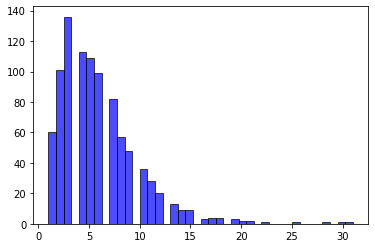

min_similarity: 0.8 K: 3


In [ ]:
min_similarity=0.8
K = get_K(sim_mat, min_similarity=min_similarity)
print('min_similarity:',min_similarity,'K:',K)

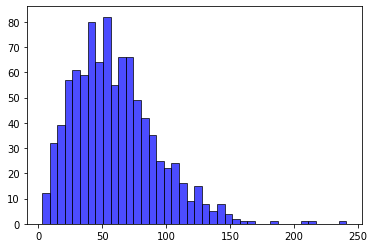

min_similarity: 0.5 K: 32


In [ ]:
min_similarity=0.5
K = get_K(sim_mat, min_similarity=min_similarity)
print('min_similarity:',min_similarity,'K:',K)

In [ ]:
def prediction(train_mat, sim_mat, K=1, model='user_based'):
    assert len(train_mat.shape)>1
    n,m = train_mat.shape
    
    if  model=='user_based':
        sim_sort = -1*np.sort(-np.array(sim_mat))[:,1:K+1] # 除去最相似的自己
        neighbors = np.argsort(-np.array(sim_mat))[:,1:K+1]
        common_items = train_mat[neighbors]>0 
        mean_user = np.reshape(np.sum(train_mat,axis=1)/np.sum(train_mat>0,axis=1), (-1,1))
        mat_m = train_mat - mean_user
        aa = np.sum(sim_sort[:,:,np.newaxis]*mat_m[neighbors]*common_items,axis=1)
        bb = np.sum(sim_sort[:,:,np.newaxis]*common_items,axis=1)+1e-10 # 1e-10保证分母不为０
        r_pred = mean_user + aa/bb
        return r_pred
    else: # 'item_based'
        r_pred=[]
        for u in range(n):
            u_mat = np.tile(train_mat[u],(m,1)) # m份用户u的记录,m*m
            rated_items_sim = (u_mat>0)*sim_mat # 保留有评分记录的相似度 m*m
            sim_sort = -1*np.sort(-np.array(rated_items_sim))[:,:K] # m*K
            neighbors = np.argsort(-np.array(rated_items_sim))[:,:K] # m*K
            neighbor_ratings = np.array([u_mat[i,neighbors[i]] for i in range(m)])# m*K
            aa = np.sum(sim_sort*neighbor_ratings,axis=1) # m*1
            bb = np.sum(sim_sort,axis=1)+1e-10 # 1e-10保证分母不为０ m*1
            r_pred.append(aa/bb)
        
        return np.array(r_pred)

In [ ]:
r_pred = prediction(train_mat=train_mat, sim_mat=sim_mat, K=K, model='user_based')

In [ ]:
n = 10
topn = get_topn(r_pred=r_pred, train_mat=train_mat, n=n)
print('user 0:')
print('top-n list:',topn[0])

user 0:
top-n list: [ 346 1453  983 1562 1135 1455    5  482  593  271]


In [ ]:
mae, rmse = mae_rmse(r_pred=r_pred, test_mat=test_mat)
print('mae:%.4f; rmse:%.4f'%(mae,rmse))
recall, precision = recall_precision(topn=topn, test_mat=test_mat)
print('recall:%.4f; precision:%.4f'%(recall,precision))

mae:0.8495; rmse:1.0855
recall:0.0118; precision:0.0251


In [ ]:
sim_mat = similarity_matrix(mat=train_mat.T, model='consine', minimum_common_items=3)
neighbors = np.argsort(-np.array(sim_mat))
sim_sort = -1*np.sort(-np.array(sim_mat))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


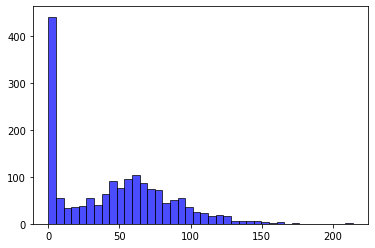

min_similarity: 0.5 K: 1


In [ ]:
min_similarity = 0.5
K = get_K(sim_mat, min_similarity=min_similarity)
print('min_similarity:',min_similarity,'K:',K)

In [ ]:
r_pred = prediction(train_mat=train_mat, sim_mat=sim_mat, K=5, model='item_based')

n = 10
topn = get_topn(r_pred=r_pred, train_mat=train_mat, n=n)

mae, rmse = mae_rmse(r_pred=r_pred, test_mat=test_mat)
print('mae:%.4f; rmse:%.4f'%(mae,rmse))
recall, precision = recall_precision(topn=topn, test_mat=test_mat)
print('recall:%.4f; precision:%.4f'%(recall,precision))

mae:0.8235; rmse:1.0665
recall:0.0080; precision:0.0171


## MF

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F6aac4ba6-d0b7-4cea-8589-f4cd93531e99%2FUntitled.png?table=block&id=ed132ae9-b7cc-43b2-85bb-eec0ce964f72&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
class mf():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 learning_rate=0.001,   # learning_rate: the learning rata
                 lamda_regularizer=0.1, # lamda_regularizer: regularization parameters
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
    
    
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],ls = self.update(P[u], Q[i], r=r, 
                                           learning_rate=self.learning_rate, 
                                           lamda_regularizer=self.lamda_regularizer)
                los += ls
            pred_mat = self.prediction(P,Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P, Q, np.array(records_list)


    def update(self, p, q, r, learning_rate=0.001, lamda_regularizer=0.1):
        error = r - np.dot(p, q.T)            
        p = p + learning_rate*(error*q - lamda_regularizer*p)
        q = q + learning_rate*(error*p - lamda_regularizer*q)
        loss = 0.5 * (error**2 + lamda_regularizer*(np.square(p).sum() + np.square(q).sum()))
        return p, q, loss


    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [ ]:
model = mf(train_list=train_list, 
           test_list=test_list, 
           N=N, 
           M=M,
           K=K,
           learning_rate=learning_rate, 
           lamda_regularizer=lamda_regularizer, 
           max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

 step:0 
 loss:549449.5639,mae:3.5169,rmse:3.6918,recall:0.0162,precision:0.0344
 step:10 
 loss:65630.3526,mae:0.7811,rmse:0.9929,recall:0.0333,precision:0.0706
 step:20 
 loss:63095.0387,mae:0.7615,rmse:0.9634,recall:0.0308,precision:0.0653
 step:30 
 loss:61813.1467,mae:0.7488,rmse:0.9466,recall:0.0331,precision:0.0701
 step:40 
 loss:60758.6475,mae:0.7382,rmse:0.9333,recall:0.0342,precision:0.0725
 step:50 
 loss:59985.8868,mae:0.7318,rmse:0.9256,recall:0.0341,precision:0.0723
 step:60 
 loss:59411.9142,mae:0.7281,rmse:0.9212,recall:0.0346,precision:0.0734
 step:70 
 loss:58989.6100,mae:0.7261,rmse:0.9190,recall:0.0323,precision:0.0684
 step:80 
 loss:58678.2983,mae:0.7252,rmse:0.9180,recall:0.0300,precision:0.0636
 step:90 
 loss:58446.1711,mae:0.7248,rmse:0.9178,recall:0.0287,precision:0.0609
 end. 
 loss:58285.9034,mae:0.7248,rmse:0.9180,recall:0.0279,precision:0.0592
MAE:0.7248;RMSE:0.9180;Recall:0.0279;Precision:0.0592


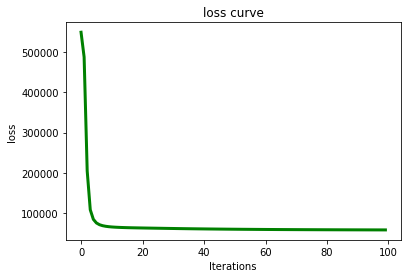

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

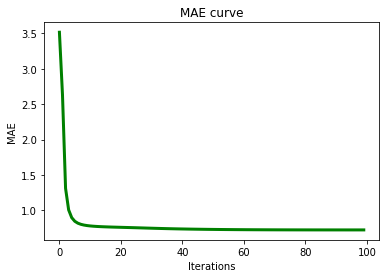

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

## NMF

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F9f5ce0ed-4f9a-4487-bc15-2303e920f640%2FUntitled.png?table=block&id=d1dd6ee8-9256-4bc4-a416-f2053c314300&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
class nmf_sgd():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 learning_rate=0.001,   # learning_rate: the learning rata
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.max_iteration = max_iteration
    
    
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],ls = self.update(P[u], Q[i], r=r, learning_rate=self.learning_rate)
                los += ls
            pred_mat = self.prediction(P,Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P,Q,np.array(records_list)


    def update(self, p, q, r, learning_rate=0.001):
        error = r - np.dot(p, q.T)            
        p = p + learning_rate*error*q
        q = q + learning_rate*error*p
        loss = 0.5 * error**2 
        return p, q, loss


    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred
		
		
class nmf_mult():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.max_iteration = max_iteration
    
    
    def train(self):
        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        avg = np.sqrt(train_mat.mean() / self.K)
        P = avg*np.random.normal(0, 1., (self.N, self.K))
        Q = avg*np.random.normal(0, 1., (self.M, self.K))

        records_list = []
        for step in range(self.max_iteration):
            P,Q = self.update(P, Q, R=train_mat)
            user = np.array(self.train_list)[:,0].astype(np.int16)
            item = np.array(self.train_list)[:,1].astype(np.int16)
            rating_true = np.array(self.train_list)[:,2]
            rating_pred = np.sum(P[user,:]*Q[item,:],axis=1)
            los = np.sum((rating_true-rating_pred)**2)
            pred_mat = self.prediction(P,Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P,Q,np.array(records_list)


    def update(self, P, Q, R ,eps=1e-6):            
        P = P * (np.dot(R+eps,Q)/(np.dot(P,np.dot(Q.T,Q)))+eps)
        Q = Q * (np.dot(R.T+eps,P)/(np.dot(Q,np.dot(P.T,P)))+eps)
        return P, Q
    
    
    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [ ]:
learning_rate = 0.005
lamda_regularizer = 0.1
max_iteration = 100
K = 10

In [ ]:
model = nmf_sgd(train_list=train_list, 
                test_list=test_list, 
                N=N, 
                M=M,
                K=K,
                learning_rate=learning_rate,
                max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

 step:0 
 loss:548038.5902,mae:3.5055,rmse:3.6806,recall:0.0280,precision:0.0595
 step:10 
 loss:35704.9549,mae:0.7664,rmse:0.9833,recall:0.0343,precision:0.0726
 step:20 
 loss:29719.9134,mae:0.7436,rmse:0.9529,recall:0.0420,precision:0.0891
 step:30 
 loss:25978.4018,mae:0.7458,rmse:0.9586,recall:0.0478,precision:0.1015
 step:40 
 loss:23907.4936,mae:0.7525,rmse:0.9709,recall:0.0466,precision:0.0989
 step:50 
 loss:22628.8693,mae:0.7586,rmse:0.9817,recall:0.0440,precision:0.0934
 step:60 
 loss:21764.8215,mae:0.7640,rmse:0.9908,recall:0.0406,precision:0.0860
 step:70 
 loss:21146.5636,mae:0.7690,rmse:0.9986,recall:0.0382,precision:0.0811
 step:80 
 loss:20685.7537,mae:0.7734,rmse:1.0054,recall:0.0346,precision:0.0734
 step:90 
 loss:20330.0393,mae:0.7773,rmse:1.0116,recall:0.0316,precision:0.0671
 end. 
 loss:20072.3955,mae:0.7805,rmse:1.0166,recall:0.0303,precision:0.0643
MAE:0.7805;RMSE:1.0166;Recall:0.0303;Precision:0.0643


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


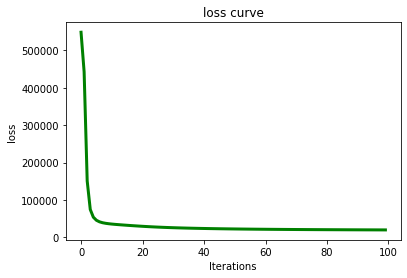

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

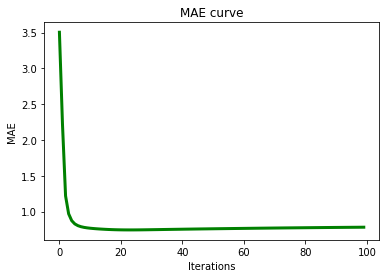

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

In [ ]:
model = nmf_mult(train_list=train_list, 
                 test_list=test_list, 
                 N=N, 
                 M=M,
                 K=K,
                 max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

 step:0 
 loss:2580523.1425,mae:3.5267,rmse:5.8206,recall:0.0259,precision:0.0549
 step:10 
 loss:2964883.3145,mae:3.8250,rmse:6.8355,recall:0.0232,precision:0.0491
 step:20 
 loss:3519744.0259,mae:3.6206,rmse:6.1980,recall:0.0217,precision:0.0461
 step:30 
 loss:2553275.7664,mae:3.5180,rmse:3.7344,recall:0.0274,precision:0.0582
 step:40 
 loss:82457928.5335,mae:4.4230,rmse:21.7644,recall:0.0219,precision:0.0464
 step:50 
 loss:49372155.9049,mae:4.8383,rmse:27.7464,recall:0.0331,precision:0.0703
 step:60 
 loss:1783316.4779,mae:3.5159,rmse:4.8778,recall:0.0226,precision:0.0479
 step:70 
 loss:1378775.2095,mae:3.4903,rmse:3.7809,recall:0.0312,precision:0.0662
 step:80 
 loss:6013408.4926,mae:3.7754,rmse:7.0817,recall:0.0381,precision:0.0807
 step:90 
 loss:1095681.3585,mae:3.4406,rmse:3.7484,recall:0.0146,precision:0.0310
 end. 
 loss:9446218.6269,mae:3.5393,rmse:3.8621,recall:0.0215,precision:0.0457
MAE:3.5393;RMSE:3.8621;Recall:0.0215;Precision:0.0457


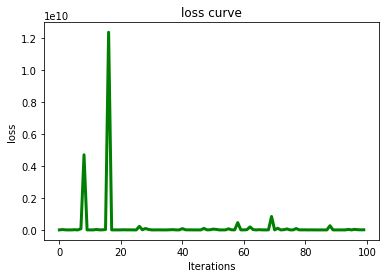

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

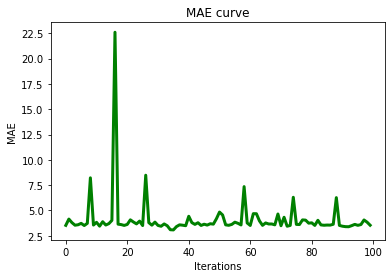

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)
train_mat = sequence2mat(sequence = train_list, N = N, M = M)
W = model.fit_transform(train_mat)
H = model.components_

def prediction(P, Q):
    N,K = P.shape
    M,K = Q.shape

    rating_list=[]
    for u in range(N):
        u_rating = np.sum(P[u,:]*Q, axis=1)
        rating_list.append(u_rating)
    r_pred = np.array(rating_list)
    return r_pred

# 预测评分
user = np.array(train_list)[:,0].astype(np.int16)
item = np.array(train_list)[:,1].astype(np.int16)
rating_true = np.array(train_list)[:,2]
rating_pred = np.sum(W[user,:]*H.T[item,:],axis=1)
loss = np.sum((rating_true-rating_pred)**2)
pred_mat = prediction(W, H.T)

# 评估算法
mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
print(loss, mae, rmse, recall, precision)

517235.90674966876 2.368676919640145 2.6390209548615853 0.1556 0.33001060445387065


## PMF

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F9b35e438-71ce-4933-b320-e8ef21cc5691%2FUntitled.png?table=block&id=8865c550-3b88-41b6-8aa4-f3eca04c31f8&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
class pmf():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 learning_rate=0.001,   # learning_rate: the learning rata
                 lamda_regularizer=0.1, # lamda_regularizer: regularization parameters
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
    
    
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],ls = self.update(P[u], Q[i], r=r, 
                                           learning_rate=self.learning_rate, 
                                           lamda_regularizer=self.lamda_regularizer)
                los += ls
            pred_mat = self.prediction(P,Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P, Q, np.array(records_list)


    def update(self, p, q, r, learning_rate=0.001, lamda_regularizer=0.1):
        error = r - np.dot(p, q.T)            
        p = p + learning_rate*(error*q - lamda_regularizer*p)
        q = q + learning_rate*(error*p - lamda_regularizer*q)
        loss = 0.5 * (error**2 + lamda_regularizer*(np.square(p).sum() + np.square(q).sum()))
        return p, q, loss


    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [ ]:
model = pmf(train_list=train_list, 
            test_list=test_list, 
            N=N, 
            M=M,
            K=K,
            learning_rate=learning_rate, 
            lamda_regularizer=lamda_regularizer, 
            max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

 step:0 
 loss:549485.5123,mae:3.5175,rmse:3.6925,recall:0.0155,precision:0.0328
 step:10 
 loss:65455.1499,mae:0.7777,rmse:0.9897,recall:0.0347,precision:0.0735
 step:20 
 loss:62521.8712,mae:0.7523,rmse:0.9537,recall:0.0367,precision:0.0778
 step:30 
 loss:61353.0497,mae:0.7414,rmse:0.9388,recall:0.0382,precision:0.0810
 step:40 
 loss:60595.2757,mae:0.7355,rmse:0.9307,recall:0.0381,precision:0.0807
 step:50 
 loss:59977.5104,mae:0.7314,rmse:0.9253,recall:0.0366,precision:0.0776
 step:60 
 loss:59462.0573,mae:0.7287,rmse:0.9219,recall:0.0331,precision:0.0703
 step:70 
 loss:59048.4957,mae:0.7272,rmse:0.9200,recall:0.0295,precision:0.0627
 step:80 
 loss:58729.0087,mae:0.7264,rmse:0.9191,recall:0.0273,precision:0.0579
 step:90 
 loss:58486.3105,mae:0.7261,rmse:0.9189,recall:0.0251,precision:0.0532
 end. 
 loss:58317.9659,mae:0.7261,rmse:0.9191,recall:0.0237,precision:0.0503
MAE:0.7261;RMSE:0.9191;Recall:0.0237;Precision:0.0503


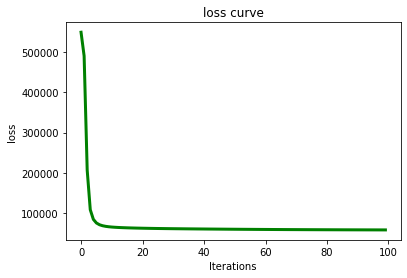

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

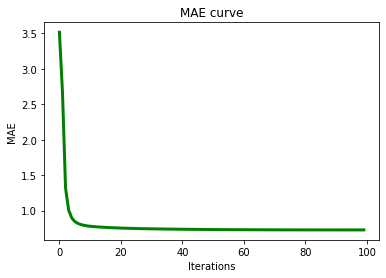

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

## WMF

In [ ]:
class wmf():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 alpha=40,              # alpha: the confidence of negtive samplers
                 lamda_regularizer=0.1, # lamda_regularizer: regularization parameters
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.alpha = alpha
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
    
    
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        records_list = []
        for step in range(self.max_iteration):
            for u in range(self.N):
                Ru = train_mat[u,:]
                P[u,:] = self.update(Q, Ru, lamda_regularizer=self.lamda_regularizer, alpha=self.alpha)

            for i in range(self.M):
                Ri = train_mat[:,i]
                Q[i,:] = self.update(P, Ri.T, lamda_regularizer=self.lamda_regularizer, alpha=self.alpha)

            pred_mat = self.prediction(P, Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([mae, rmse, recall, precision]))

            print(' step:%d \n mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'%(step,mae,rmse,recall,precision))

        print(' end. \n mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3]))
        return P, Q, np.array(records_list)


    def update(self, P, Ru, lamda_regularizer=0.1, alpha=40):
        # P: N/M *K
        # Ru: N/M *1
        N, K = P.shape
        c_ui = 1 + alpha*Ru
        Cu = c_ui* np.eye(N)   

        YtCY_I = P.T.dot(Cu).dot(P) + lamda_regularizer*np.eye(K)
        YtCRu = P.T.dot(Cu).dot(Ru)
        p = np.linalg.inv(YtCY_I).dot(YtCRu)
        return p.T


    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [ ]:
max_iteration = 10
alpha=40

In [ ]:
model = wmf(train_list=train_list, 
            test_list=test_list, 
            N=N, 
            M=M,
            K=K,
            alpha=alpha,
            lamda_regularizer=lamda_regularizer, 
            max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,0][-1],records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1]))

 step:0 
 mae:2.2314,rmse:2.7460,recall:0.0182,precision:0.0386
 step:1 
 mae:0.8536,rmse:1.1179,recall:0.0722,precision:0.1530
 step:2 
 mae:0.8400,rmse:1.1036,recall:0.0751,precision:0.1593
 step:3 
 mae:0.8361,rmse:1.1002,recall:0.0759,precision:0.1610
 step:4 
 mae:0.8343,rmse:1.0983,recall:0.0775,precision:0.1644
 step:5 
 mae:0.8329,rmse:1.0969,recall:0.0777,precision:0.1648
 step:6 
 mae:0.8319,rmse:1.0959,recall:0.0776,precision:0.1646
 step:7 
 mae:0.8313,rmse:1.0954,recall:0.0776,precision:0.1647
 step:8 
 mae:0.8308,rmse:1.0953,recall:0.0786,precision:0.1667
 step:9 
 mae:0.8303,rmse:1.0954,recall:0.0788,precision:0.1671
 end. 
 mae:0.8303,rmse:1.0954,recall:0.0788,precision:0.1671
MAE:0.8303;RMSE:1.0954;Recall:0.0788;Precision:0.1671


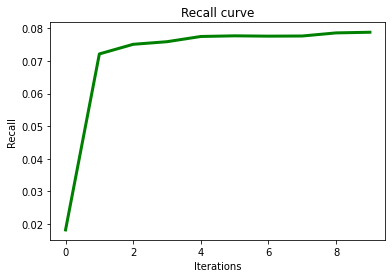

In [ ]:
plot_figure(values_list=records_array[:,2],name='Recall')

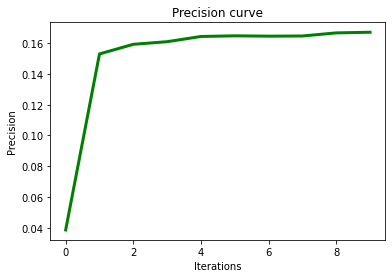

In [ ]:
plot_figure(values_list=records_array[:,3],name='Precision')

## SVD

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ff4d94b05-ddb7-4b90-9d74-df995650ca8e%2FUntitled.png?table=block&id=4f6d01de-c8ca-4ccb-8c8c-fe9260f7fcb0&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
from sklearn.utils.extmath import randomized_svd
def puresvd(R = None, # train mat
            k=150, # the number of latent factor
            ):
    P, sigma, QT = randomized_svd(R, k)
    sigma = scipy.sparse.diags(sigma, 0)
    P = P * sigma
    Q = QT.T   
    # R_= np.dot(P, QT)
    R_ = np.dot(R, np.dot(Q, QT)) #
    return R_

In [ ]:
R_score = puresvd(R=train_mat, k=K)
mae, rmse, recall, precision = evaluation(pred_mat=R_score, train_mat=train_mat, test_mat=test_mat)
print('mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'%(mae,rmse,recall,precision))

## BiasSVD

In [ ]:
class biassvd():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 learning_rate=0.001,   # learning_rate: the learning rata
                 lamda_regularizer=0.1, # lamda_regularizer: regularization parameters
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
        
        
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))
        bu = np.zeros([self.N])
        bi = np.zeros([self.M])

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        aveg_rating = np.mean(train_mat[train_mat>0])

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],bu[u],bi[i],ls = self.update(P[u], Q[i], bu=bu[u], bi=bi[i], 
                                                       aveg_rating=aveg_rating, r=r,
                                                       learning_rate=self.learning_rate, 
                                                       lamda_regularizer=self.lamda_regularizer)
                los += ls
            pred_mat = self.prediction(P, Q, bu, bi, aveg_rating)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P, Q, bu, bi, np.array(records_list)


    def prediction(self, P, Q, bu, bi, aveg_rating):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = aveg_rating + bu[u] + bi + np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred


    def update(self, p, q, bu, bi, aveg_rating, r, learning_rate=0.001, lamda_regularizer=0.1):
        error = r - (aveg_rating + bu + bi + np.dot(p, q.T))            
        p = p + learning_rate*(error*q - lamda_regularizer*p)
        q = q + learning_rate*(error*p - lamda_regularizer*q)
        bu = bu + learning_rate*(error - lamda_regularizer*bu)
        bi = bi + learning_rate*(error - lamda_regularizer*bi)
        loss = 0.5 * (error**2 + lamda_regularizer*(np.square(p).sum() + np.square(q).sum()) + bu**2 + bi**2)
        return p, q, bu, bi, loss

In [ ]:
max_iteration = 100
model = biassvd(train_list=train_list, 
                test_list=test_list, 
                N=N, 
                M=M,
                K=K,
                learning_rate=learning_rate, 
                lamda_regularizer=lamda_regularizer, 
                max_iteration=max_iteration)
P, Q, bu, bi, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

 step:0 
 loss:46872.3253,mae:0.8161,rmse:1.0085,recall:0.0638,precision:0.1353
 step:10 
 loss:47453.6253,mae:0.7516,rmse:0.9502,recall:0.0358,precision:0.0759
 step:20 
 loss:47772.9913,mae:0.7465,rmse:0.9452,recall:0.0295,precision:0.0626
 step:30 
 loss:47453.6354,mae:0.7410,rmse:0.9391,recall:0.0304,precision:0.0645
 step:40 
 loss:46753.5474,mae:0.7329,rmse:0.9298,recall:0.0302,precision:0.0641
 step:50 
 loss:46051.6004,mae:0.7273,rmse:0.9228,recall:0.0323,precision:0.0686
 step:60 
 loss:45389.8553,mae:0.7237,rmse:0.9184,recall:0.0321,precision:0.0682
 step:70 
 loss:44785.6377,mae:0.7214,rmse:0.9157,recall:0.0299,precision:0.0634
 step:80 
 loss:44272.4167,mae:0.7202,rmse:0.9143,recall:0.0278,precision:0.0590
 step:90 
 loss:43856.1163,mae:0.7197,rmse:0.9137,recall:0.0256,precision:0.0543
 end. 
 loss:43554.0978,mae:0.7196,rmse:0.9137,recall:0.0233,precision:0.0495
MAE:0.7196;RMSE:0.9137;Recall:0.0233;Precision:0.0495


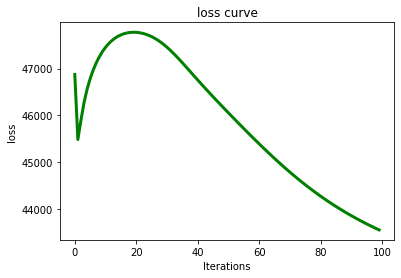

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

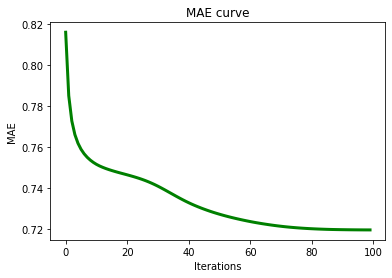

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

## SVD++

In [ ]:
class svdplus():
    def __init__(self, 
                 train_list,            # train_list: train data 
                 test_list,             # test_list: test data
                 N,                     # N:the number of user
                 M,                     # M:the number of item
                 K=10,                  # K: the number of latent factor
                 learning_rate=0.001,   # learning_rate: the learning rata
                 lamda_regularizer=0.1, # lamda_regularizer: regularization parameters
                 max_iteration=50       # max_iteration: the max iteration
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
    
    
    def train(self): 
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))
        Y = np.random.normal(0, 0.1, (self.M, self.K))
        bu = np.zeros([self.N])
        bi = np.zeros([self.M])

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        aveg_rating = np.mean(train_mat[train_mat>0])

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],bu[u],bi[i],Y, ls = self.update(p=P[u], q=Q[i], bu=bu[u], bi=bi[i], Y=Y, 
                                                          aveg_rating=aveg_rating, r=r,Ru = train_mat[u], 
                                                          learning_rate=self.learning_rate, 
                                                          lamda_regularizer=self.lamda_regularizer)
                los += ls
            pred_mat = self.prediction(P, Q, Y, bu, bi, aveg_rating, train_mat)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P, Q, Y, bu, bi, np.array(records_list)


    def update(self, p, q, bu, bi, Y, aveg_rating, r, Ru, learning_rate=0.001, lamda_regularizer=0.1):
        Iu = np.sum(Ru>0)
        y_sum = np.sum(Y[np.where(Ru>0)], axis=0)
        error = r - (aveg_rating + bu + bi + np.dot(p+Iu**(-0.5)*y_sum, q.T))            
        p = p + learning_rate*(error*q - lamda_regularizer*p)
        q = q + learning_rate*(error*(p + Iu**(-0.5)*y_sum) - lamda_regularizer*q)
        bu = bu + learning_rate*(error - lamda_regularizer*bu)
        bi = bi + learning_rate*(error - lamda_regularizer*bi)

        l = 0
        for j in np.where(Ru>0):
            Y[j] = Y[j] + learning_rate*(error*Iu**(-0.5)*q - lamda_regularizer*Y[j])
            l = l + np.square(Y[j]).sum()

        loss = 0.5 * (error**2 + lamda_regularizer*(np.square(p).sum() + np.square(q).sum()) + bu**2 + bi**2 + l)
        return p, q, bu, bi, Y, loss


    def prediction(self, P, Q, Y, bu, bi, aveg_rating, R):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            Ru = R[u]
            Iu = np.sum(Ru>0)
            y_sum = np.sum(Y[np.where(Ru>0)],axis=0)
            u_rating = aveg_rating + bu[u]+ bi + np.sum((P[u,:]+Iu**(-0.5)*y_sum)*Q,axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [ ]:
model = svdplus(train_list=train_list, 
                test_list=test_list, 
                N=N, 
                M=M,
                K=K,
                learning_rate=learning_rate, 
                lamda_regularizer=lamda_regularizer, 
                max_iteration=max_iteration)
P, Q, Y, bu, bi, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

In [ ]:
plot_figure(values_list=records_array[:,0],name='loss')

In [ ]:
plot_figure(values_list=records_array[:,1],name='MAE')

## MLP

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fd5fbd3d9-147f-4bd2-8ba2-9d92e59935a0%2FUntitled.png?table=block&id=ce89cc19-d2c6-45ab-a02b-ddc7765d47c6&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2' width=50%>

In [ ]:
class mlp():
    def __init__(self,               
                 users_num = None,
                 items_num = None,
                 embedding_size = 16,
                 hidden_sizes = [16,8],
                 learning_rate = 1e-3,
                 lamda_regularizer=1e-3,
                 batch_size = 256
                ):
        self.users_num = users_num
        self.items_num = items_num
        self.embedding_size = embedding_size
        self.hidden_sizes = hidden_sizes
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.batch_size = batch_size

        # loss records
        self.train_loss_records = []  
        self.build_graph()   

        
    def build_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():       
            # _________ input data _________
            self.users_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None], name='users_inputs')
            self.items_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None], name='items_inputs')
            self.train_labels = tf.compat.v1.placeholder(tf.float32, shape = [None], name='train_labels') 
            
            # _________ variables _________
            self.weights = self._initialize_weights()
            
            # _________ train _____________
            self.y_ = self.inference(users_inputs=self.users_inputs, items_inputs=self.items_inputs)
            self.loss_train = self.loss_function(true_labels=self.train_labels, 
                                                 predicted_labels=tf.reshape(self.y_,shape=[-1]),
                                                 lamda_regularizer=self.lamda_regularizer)
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate,beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(self.loss_train) 

            # _________ prediction _____________
            self.predictions = self.inference(users_inputs=self.users_inputs, items_inputs=self.items_inputs)
        
            #变量初始化 init 
            init = tf.compat.v1.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
    
    
    def _init_session(self):
        # adaptively growing memory
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        return tf.compat.v1.Session(config=config)
    
    
    def _initialize_weights(self):
        all_weights = dict()

        # -----embedding layer------
        all_weights['embedding_users'] = tf.Variable(tf.random.normal([self.users_num, self.embedding_size],0, 0.1),name='embedding_users')
        all_weights['embedding_items'] = tf.Variable(tf.random.normal([self.items_num, self.embedding_size],
                                                                      0, 0.1),name='embedding_items') 
        
        # ------hidden layer------
        all_weights['weight_0'] = tf.Variable(tf.random.normal([self.embedding_size * 2,self.hidden_sizes[0]], 0.0, 0.1),name='weight_0')
        all_weights['bias_0'] = tf.Variable(tf.zeros([self.hidden_sizes[0]]), name='bias_0')
        all_weights['weight_1'] = tf.Variable(tf.random.normal([self.hidden_sizes[0],self.hidden_sizes[1]], 0.0, 0.1), name='weight_1')
        all_weights['bias_1'] = tf.Variable(tf.zeros([self.hidden_sizes[1]]), name='bias_1')
        
        # ------output layer-----
        all_weights['weight_n'] = tf.Variable(tf.random.normal([self.hidden_sizes[-1], 1], 0, 0.1), name='weight_n')
        all_weights['bias_n'] = tf.Variable(tf.zeros([1]), name='bias_n')
        return all_weights
        
    
    def train(self, data_sequence):
        train_size = len(data_sequence)
        batch_size = self.batch_size
        total_batch = math.ceil(train_size/batch_size)

        for batch in range(total_batch):
            start = (batch*batch_size)% train_size
            end = min(start+batch_size, train_size)
            data_array = np.array(data_sequence[start:end])
            X = data_array[:,:2] # u,i
            y = data_array[:,-1] # label

            feed_dict = {self.users_inputs: X[:,0], self.items_inputs: X[:,1], self.train_labels:y}  
            loss, opt = self.sess.run([self.loss_train,self.train_op], feed_dict=feed_dict)
            self.train_loss_records.append(loss)
            
        return self.train_loss_records


    def inference(self, users_inputs, items_inputs):
        embed_users = tf.reshape(tf.nn.embedding_lookup(self.weights['embedding_users'], users_inputs),
                                 shape=[-1, self.embedding_size])
        embed_items = tf.reshape(tf.nn.embedding_lookup(self.weights['embedding_items'], items_inputs),
                                 shape=[-1, self.embedding_size])
            
        layer0 = tf.nn.relu(tf.matmul(tf.concat([embed_items,embed_users],1), self.weights['weight_0']) + self.weights['bias_0'])
        layer1 = tf.nn.relu(tf.matmul(layer0, self.weights['weight_1']) + self.weights['bias_1'])       
        y_ = tf.matmul(layer1,self.weights['weight_n']) + self.weights['bias_n']
        return y_         
        
        
    def loss_function(self, true_labels, predicted_labels,lamda_regularizer=1e-3):   
        loss = tf.compat.v1.losses.mean_squared_error(true_labels, predicted_labels)
        cost = loss
        if lamda_regularizer>0:
            regularizer_1 = tf.contrib.layers.l2_regularizer(lamda_regularizer)
            regularization = regularizer_1(
                self.weights['embedding_users']) + regularizer_1(
                self.weights['embedding_items'])+ regularizer_1(
                self.weights['weight_0']) + regularizer_1(
                self.weights['weight_1']) + regularizer_1(
                self.weights['weight_n'])
            cost = loss + regularization

        return cost   
    
    
    def predict_ratings(self, data_sequence):
        pred_mat = np.zeros([self.users_num, self.items_num])
        
        instances_size = len(data_sequence)
        data_array = np.array(data_sequence)
        items_id = np.array([i for i in range(self.items_num)])
        for u in range(self.users_num):
            users_id = u*np.ones_like(items_id)
            feed_dict = {self.users_inputs:users_id, 
                         self.items_inputs:items_id}  
            out = self.sess.run([self.predictions], feed_dict=feed_dict)
            pred_mat[u] = np.reshape(out,(-1))

        return pred_mat

In [ ]:
users_num = N
items_num = M
hidden_size = 500
batch_size = 256
lamda_regularizer = 1e-3
learning_rate = 1e-4
epoches  = 100
embedding_size = 8

In [ ]:
learning_rate = 1e-4
hidden_sizes = [embedding_size,int(embedding_size/2)]
model = mlp(users_num = users_num,
            items_num = items_num,
            embedding_size = embedding_size,
            hidden_sizes = hidden_sizes,
            learning_rate = learning_rate,
            lamda_regularizer = lamda_regularizer,
            batch_size = batch_size)

records_list = []
input_data = train_list
for epoch in range(epoches):
    data_mat = np.random.permutation(input_data) 
    loss = model.train(data_sequence=data_mat)
    pred_mat = model.predict_ratings(data_sequence=test_list)
    mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
    records_list.append([loss[-1],mae, rmse, recall, precision])
    if epoch % 10==0:
        topn = get_topn(pred_mat, train_mat, n=10)
        hit_list, ndcg_list = hit_ndcg(test_sequence=np.array(test_list), ranklist=topn)
        hit, ndcg = np.array(hit_list).mean(),np.array(ndcg_list).mean()
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f; Hit=%.4f; NDCG=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision, hit, ndcg))

epoch:0  loss=14.1272; 
 MAE=3.4707; RMSE=3.6485; Recall=0.0110; Precision=0.0233; Hit=0.0110; NDCG=0.0049
epoch:10  loss=0.9330; 
 MAE=0.8052; RMSE=1.0114; Recall=0.0621; Precision=0.1317; Hit=0.0621; NDCG=0.0305
epoch:20  loss=1.1057; 
 MAE=0.7549; RMSE=0.9589; Recall=0.0452; Precision=0.0959; Hit=0.0452; NDCG=0.0189
epoch:30  loss=1.0902; 
 MAE=0.7459; RMSE=0.9493; Recall=0.0403; Precision=0.0856; Hit=0.0403; NDCG=0.0165
epoch:40  loss=1.0826; 
 MAE=0.7434; RMSE=0.9463; Recall=0.0376; Precision=0.0796; Hit=0.0376; NDCG=0.0154
epoch:50  loss=0.9546; 
 MAE=0.7424; RMSE=0.9454; Recall=0.0367; Precision=0.0777; Hit=0.0367; NDCG=0.0152
epoch:60  loss=1.1408; 
 MAE=0.7416; RMSE=0.9450; Recall=0.0360; Precision=0.0764; Hit=0.0360; NDCG=0.0147
epoch:70  loss=0.7712; 
 MAE=0.7419; RMSE=0.9446; Recall=0.0323; Precision=0.0685; Hit=0.0323; NDCG=0.0136
epoch:80  loss=0.9435; 
 MAE=0.7416; RMSE=0.9446; Recall=0.0323; Precision=0.0684; Hit=0.0323; NDCG=0.0135
epoch:90  loss=0.7107; 
 MAE=0.7416; 

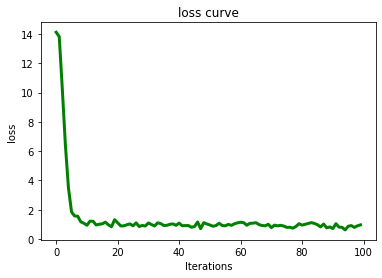

In [ ]:
plot_figure(values_list=np.array(records_list)[:,0],name='loss')

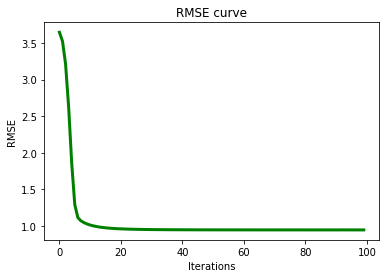

In [ ]:
plot_figure(values_list=np.array(records_list)[:,2],name='RMSE')

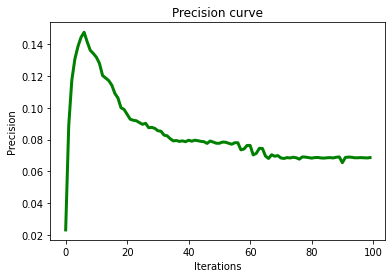

In [ ]:
plot_figure(values_list=np.array(records_list)[:,-1],name='Precision')

## AutoRec

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F23e2e6a6-6a9b-4a78-b5ca-ad61f89c1633%2FUntitled.png?table=block&id=29caaba9-6e27-49aa-8737-da51c3575af2&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
class autorec():
    def __init__(self,
                 users_num = None,         #用户数
                 items_num = None,         #商品数
                 hidden_size = 500,        #隐层节点数目，即用户的嵌入空间维度
                 batch_size = 256,         #batch大小
                 learning_rate = 1e-3,     #学习率
                 lamda_regularizer = 1e-3, #正则项系数
                ):
        self.users_num = users_num
        self.items_num = items_num
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        
        self.train_loss_records = []  
        self.build_graph()   

        
    def build_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():      
            # _________ input data _________
            self.rating_inputs = tf.compat.v1.placeholder(tf.float32, shape = [None, self.items_num], name='rating_inputs')
            
            # _________ variables _________
            self.weights = self._initialize_weights()
            
            # _________ train _____________
            self.y_ = self.inference(rating_inputs=self.rating_inputs)
            self.loss_train = self.loss_function(true_r=self.rating_inputs, predicted_r=self.y_, lamda_regularizer=self.lamda_regularizer)
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(self.loss_train) 
        
            # _________ prediction _____________
            self.predictions = self.inference(rating_inputs=self.rating_inputs)
            
            #变量初始化 init 
            init = tf.compat.v1.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
    
    
    def _init_session(self):
        # adaptively growing memory
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        return tf.compat.v1.Session(config=config)
    
    
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['V'] = tf.Variable(tf.random.normal([self.items_num, self.hidden_size], 0.0, 0.1), name='V')
        all_weights['mu'] = tf.Variable(tf.zeros([self.hidden_size]), name='mu')
        all_weights['W'] = tf.Variable(tf.random.normal([self.hidden_size, self.items_num], 0.0, 0.1), name='W')
        all_weights['b'] = tf.Variable(tf.zeros([self.items_num]), name='b')
        return all_weights
    
    
    def train(self, data_mat):
        instances_size = len(data_mat)
        batch_size = self.batch_size
        total_batch = math.ceil(instances_size/batch_size)
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size)
            feed_dict = {self.rating_inputs: data_mat[start:end]}  
            loss, opt = self.sess.run([self.loss_train, self.train_op], feed_dict=feed_dict)
            self.train_loss_records.append(loss)
            
        return self.train_loss_records

        
    # 网络的前向传播
    def inference(self, rating_inputs):
        encoder = tf.nn.sigmoid(tf.matmul(rating_inputs, self.weights['V']) + self.weights['mu'])
        decoder = tf.identity(tf.matmul(encoder, self.weights['W']) + self.weights['b'])
        return decoder         
        
        
    def loss_function(self, true_r, predicted_r, lamda_regularizer=1e-3):
        idx = tf.where(true_r>0)
        true_y = tf.gather_nd(true_r, idx)
        predicted_y = tf.gather_nd(predicted_r, idx)
        mse = tf.compat.v1.losses.mean_squared_error(true_y, predicted_y)
        regularizer = tf.contrib.layers.l2_regularizer(lamda_regularizer)
        regularization = regularizer(self.weights['V']) + regularizer(self.weights['W'])
        cost = mse + regularization
        return cost 
    
    
    def predict_ratings(self, data_mat):
        pred_mat = np.zeros([self.users_num, self.items_num])
        
        instances_size = len(data_mat)
        batch_size = self.batch_size
        total_batch = math.ceil(instances_size/batch_size)
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size)
            feed_dict = {self.rating_inputs: data_mat[start:end]}  
            out = self.sess.run([self.predictions], feed_dict=feed_dict)
            pred_mat[start:end,:] = np.reshape(out,(-1,self.items_num))

        return pred_mat

In [ ]:
users_num = N
items_num = M
hidden_size = 500
batch_size = 256
lamda_regularizer = 1e-3
learning_rate = 1e-3
epoches  = 100
embedding_size = 8

In [ ]:
model = autorec(users_num = users_num,
                items_num = items_num,
                hidden_size = hidden_size,
                batch_size = batch_size,
                learning_rate = learning_rate,
                lamda_regularizer = lamda_regularizer)

records_list = []
for epoch in range(epoches):
    data_mat = np.random.permutation(train_mat) 
    loss = model.train(data_mat=data_mat)
    pred_mat = model.predict_ratings(data_mat=train_mat)
    mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
    records_list.append([loss[-1],mae, rmse, recall, precision])
    if epoch % 10==0:
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision))

epoch:0  loss=24.2964; 
 MAE=3.5297; RMSE=3.9273; Recall=0.0103; Precision=0.0217
epoch:10  loss=16.9620; 
 MAE=2.5527; RMSE=2.9667; Recall=0.0167; Precision=0.0354
epoch:20  loss=12.6437; 
 MAE=1.7899; RMSE=2.1856; Recall=0.0200; Precision=0.0424
epoch:30  loss=10.4896; 
 MAE=1.3248; RMSE=1.6534; Recall=0.0243; Precision=0.0514
epoch:40  loss=9.4038; 
 MAE=1.1130; RMSE=1.3923; Recall=0.0246; Precision=0.0522
epoch:50  loss=8.9156; 
 MAE=1.0301; RMSE=1.2882; Recall=0.0238; Precision=0.0504
epoch:60  loss=8.6506; 
 MAE=0.9955; RMSE=1.2448; Recall=0.0243; Precision=0.0514
epoch:70  loss=8.3318; 
 MAE=0.9777; RMSE=1.2228; Recall=0.0240; Precision=0.0509
epoch:80  loss=8.1872; 
 MAE=0.9658; RMSE=1.2083; Recall=0.0240; Precision=0.0510
epoch:90  loss=7.8398; 
 MAE=0.9569; RMSE=1.1974; Recall=0.0237; Precision=0.0503


In [ ]:
plot_figure(values_list=np.array(records_list)[:,0],name='loss')

In [ ]:
plot_figure(values_list=np.array(records_list)[:,2],name='RMSE')

In [ ]:
plot_figure(values_list=np.array(records_list)[:,-1],name='Precision')

## CDAE

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ffb4cd4c9-0c90-4ab9-88a5-a9ce533f324d%2FUntitled.png?table=block&id=5694096f-ced8-428c-ada2-4a4e2e5a923f&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
class cdae():
    def __init__(self,
                 users_num = None,         #用户数
                 items_num = None,         #商品数
                 hidden_size = 500,        #隐层节点数目，即用户的嵌入空间维度
                 batch_size = 256,         #batch大小
                 learning_rate = 1e-3,     #学习率
                 lamda_regularizer = 1e-3, #正则项系数
                 dropout_rate = 0.5,       # dropout rate
                 noise_level = 1e-3
                ):
        self.users_num = users_num
        self.items_num = items_num
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.dropout_rate = dropout_rate
        self.noise_level = noise_level
        
        self.train_loss_records = []  
        self.build_graph()   

        
    def build_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():      
            # _________ input data _________
            self.rating_inputs = tf.compat.v1.placeholder(tf.float32, shape = [None, self.items_num], name='rating_inputs')
            self.user_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None, 1], name='user_inputs')
            self.dropout_prob = tf.compat.v1.placeholder(tf.float32, name = "dropout_prob")

            # _________ variables _________
            self.weights = self._initialize_weights()
            
            # _________ train _____________
            self.y_ = self.inference(rating_inputs=self.rating_inputs, user_inputs=self.user_inputs)
            self.loss_train = self.loss_function(true_r=self.corrupted_inputs, predicted_r=self.y_, lamda_regularizer=self.lamda_regularizer)
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(self.loss_train) 
        
            # _________ prediction _____________
            self.predictions = self.inference(rating_inputs=self.rating_inputs, user_inputs=self.user_inputs)
            
            #变量初始化 init 
            init = tf.compat.v1.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
    
    
    def _init_session(self):
        # adaptively growing memory
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        return tf.compat.v1.Session(config=config)
    
    
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['W1'] = tf.Variable(tf.random.normal([self.items_num, self.hidden_size], 0.0, 0.1), name='W1')
        all_weights['b1'] = tf.Variable(tf.zeros([self.hidden_size]), name='b1')
        all_weights['W2'] = tf.Variable(tf.random.normal([self.hidden_size, self.items_num], 0.0, 0.1), name='W2')
        all_weights['b2'] = tf.Variable(tf.zeros([self.items_num]), name='b2')
        all_weights['V'] = tf.Variable(tf.zeros([self.users_num, self.hidden_size]), name='V')
        return all_weights
    
    
    def train(self, data_mat):
        instances_size = len(data_mat)
        batch_size = self.batch_size
        total_batch = math.ceil(instances_size/batch_size)
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size)
            feed_dict = {self.user_inputs:np.reshape(data_mat[start:end,0],(-1,1)), 
                         self.rating_inputs:data_mat[start:end,1:], 
                         self.dropout_prob:self.dropout_rate}  
            loss, opt = self.sess.run([self.loss_train, self.train_op], feed_dict=feed_dict)
            self.train_loss_records.append(loss)
            
        return self.train_loss_records

        
    # 网络的前向传播
    def inference(self, rating_inputs, user_inputs):
        inputs_noisy = rating_inputs + self.noise_level * tf.random_normal(tf.shape(rating_inputs))
        self.corrupted_inputs = tf.nn.dropout(inputs_noisy, rate=self.dropout_prob)
        Vu = tf.reshape(tf.nn.embedding_lookup(self.weights['V'], user_inputs),(-1, self.hidden_size))
        encoder = tf.nn.sigmoid(tf.matmul(self.corrupted_inputs, self.weights['W1']) + Vu + self.weights['b1'])
        decoder = tf.identity(tf.matmul(encoder, self.weights['W2']) + self.weights['b2'])
        return decoder         
        
        
    def loss_function(self, true_r, predicted_r, lamda_regularizer=1e-3, loss_type='square'):
        idx = tf.where(true_r>0)
        true_y = tf.gather_nd(true_r, idx)
        predicted_y = tf.gather_nd(predicted_r, idx)
       
        if loss_type=='square':
            loss = tf.compat.v1.losses.mean_squared_error(true_y, predicted_y)
        elif loss_type=='cross_entropy':
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=true_y, logits=predicted_y)
        
        regularizer = tf.contrib.layers.l2_regularizer(lamda_regularizer)
        regularization = regularizer(self.weights['V']) + regularizer(self.weights['W1']) + regularizer(
            self.weights['W2']) + regularizer(self.weights['b1']) + regularizer(self.weights['b2'])
        cost = loss + regularization
        return cost 
    
    
    def predict_ratings(self, data_mat):
        pred_mat = np.zeros([self.users_num, self.items_num])
        
        instances_size = len(data_mat)
        batch_size = self.batch_size
        total_batch = math.ceil(instances_size/batch_size)
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size)
            feed_dict = {self.user_inputs:np.reshape(data_mat[start:end,0],(-1,1)), 
                         self.rating_inputs:data_mat[start:end,1:],
                         self.dropout_prob:0.}  
            out = self.sess.run([self.predictions], feed_dict=feed_dict)
            pred_mat[start:end,:] = np.reshape(out,(-1,self.items_num))

        return pred_mat

In [ ]:
users_num = N
items_num = M
hidden_size = 50
batch_size = 256
lamda_regularizer = 1e-2
learning_rate = 0.01
epoches  = 100
embedding_size = 8
hidden_size = 50
dropout_rate = 0.5

In [ ]:
model = cdae(users_num = users_num,
             items_num = items_num,
             hidden_size = hidden_size,
             batch_size = batch_size,
             learning_rate = learning_rate,
             lamda_regularizer = lamda_regularizer,
             dropout_rate = dropout_rate)

user_array = np.array([u for u in range(users_num)])
input_data = np.c_[user_array, train_mat]
records_list = []
for epoch in range(epoches):
    data_mat = np.random.permutation(input_data) 
    loss = model.train(data_mat=data_mat)
    pred_mat = model.predict_ratings(data_mat=np.c_[user_array, train_mat])
    mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
    records_list.append([loss[-1],mae, rmse, recall, precision])
    if epoch % 10==0:
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision))

epoch:0  loss=10.3755; 
 MAE=2.8404; RMSE=3.0550; Recall=0.0570; Precision=0.1208
epoch:10  loss=4.4843; 
 MAE=1.9206; RMSE=2.2486; Recall=0.1089; Precision=0.2309
epoch:20  loss=3.7899; 
 MAE=1.9118; RMSE=2.2383; Recall=0.1076; Precision=0.2282
epoch:30  loss=4.1955; 
 MAE=1.9184; RMSE=2.2458; Recall=0.1118; Precision=0.2370
epoch:40  loss=4.1775; 
 MAE=1.9164; RMSE=2.2450; Recall=0.1080; Precision=0.2291
epoch:50  loss=3.7932; 
 MAE=1.9130; RMSE=2.2392; Recall=0.1067; Precision=0.2263
epoch:60  loss=3.8836; 
 MAE=1.9184; RMSE=2.2473; Recall=0.1114; Precision=0.2362
epoch:70  loss=4.1528; 
 MAE=1.9213; RMSE=2.2488; Recall=0.1026; Precision=0.2176
epoch:80  loss=4.0620; 
 MAE=1.9569; RMSE=2.2818; Recall=0.1072; Precision=0.2274
epoch:90  loss=4.4991; 
 MAE=1.9058; RMSE=2.2374; Recall=0.1050; Precision=0.2227


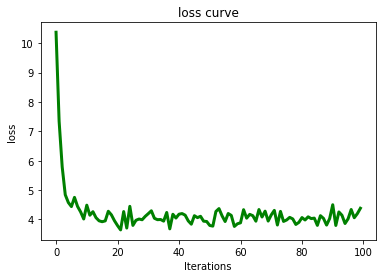

In [ ]:
plot_figure(values_list=np.array(records_list)[:,0],name='loss')

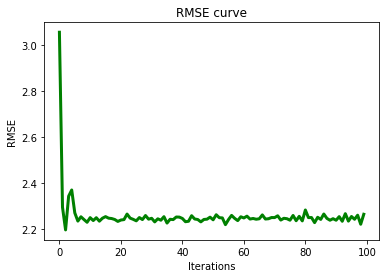

In [ ]:
plot_figure(values_list=np.array(records_list)[:,2],name='RMSE')

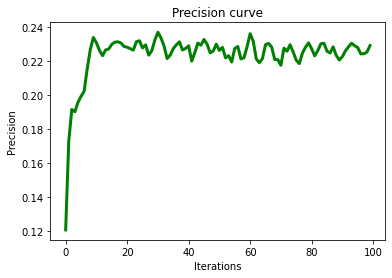

In [ ]:
plot_figure(values_list=np.array(records_list)[:,-1],name='Precision')